### NB1: Python3.5+ is needed here
### NB2: get and compile the maser4py library before running this notebook
__Details__

Location of repository: https://github.com/maserlib/maser4py
Name of Branch to use: feature/data

__Instructions__
```
mkdir src
cd src
git clone https://github.com/maserlib/maser4py
cd maser4py
git checkout feature/data
python3 setup.py install
```


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import maser.data.pds.ppi.cassini.rpws.wbr as wbr
import numpy
import scipy
import datetime

In [2]:
# loading file in PDSPPICassiniRPWSWBRFullResDataFromLabel object
file = '/Users/baptiste/Downloads/CO-V_E_J_S_SS-RPWS-2-REFDR-WBRFULL-V1/T2000366_09_8025KHZ4_WBRFR.LBL'
o = wbr.PDSPPICassiniRPWSWBRFullResDataFromLabel(file)
print(o.objects)

['TIME_SERIES', 'WBR_ROW_PREFIX_TABLE']


In [3]:
(n_sample, sample_length) = o.object['TIME_SERIES'].data['WBR_SAMPLE'].shape
print("Current WBR file contains {} samples, with {} data points each".format(n_sample, sample_length))

Current WBR file contains 479 samples, with 4096 data points each


In [4]:
# checking for the WBR sample with the largest signal

value_max = 0
index_max = 0
for i_sample in range(o.object['TIME_SERIES'].data.n_rows):
    # for each WBR sample, remove the offset value, compute the largest absolute signal and compare to previous max
    data = numpy.abs(o.object['TIME_SERIES'].data['WBR_SAMPLE'][i_sample]-127.5)
    if numpy.max(data) > value_max:
        # max value exceeds previous detected max, update the detection
        value_max = numpy.max(data)
        index_max = i_sample

# print out the detected max values:
print("Largest signal decteted in WBR sample #{}, with value = {}".format(index_max, value_max))

Largest signal decteted in WBR sample #5, with value = 62.5


In [5]:
i_sample = 5  # This is the sample with the highest signal

time_ramp = o.get_sample_time_axis()
time_sampling_step = time_ramp[1]
date_sample = o.get_start_sample_datetime()[i_sample]
frequency = o.get_central_frequency()[i_sample]
wbr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.gain[i_sample]['TOTAL_GAIN']

data = o.object['TIME_SERIES'].data['WBR_SAMPLE'][i_sample]

# Calibrating according to RPWSCAL.PDF document of CO-V_E_J_S_SS-RPWS-2-REFDR-WBRFULL-V1 PDS3 volume at PDS/PPI 
# NB: this document doesn't tell how to calibrate the HFR front end.

data_cal = (data - numpy.average(data))/267.31/10**(wbr_gain/20)

# The HFR gain is given by the AGC value given in the WBR_ROW_PREFIX_TABLE
# the get_agc_gain() methods converts the AGC value into a gain on dB (using HFR specific calibration parameters)
hfr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.get_agc_gain()[i_sample]


In [15]:
(o.get_start_sample_datetime()[1]-o.get_start_sample_datetime()[0]).total_seconds()

0.25

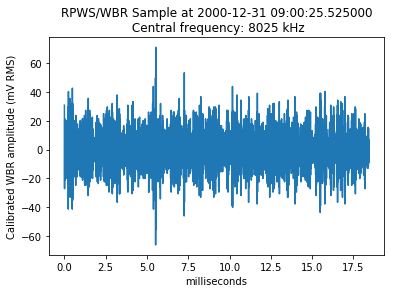

In [5]:
plt.plot(time_ramp*1000, data_cal*1000) #time in ms, data in mV
plt.title("RPWS/WBR Sample at {}\n Central frequency: {} kHz".format(date_sample, frequency))
plt.xlabel('milliseconds')
plt.ylabel('Calibrated WBR amplitude (mV RMS)')

In [6]:
numpy.average(data)

129.9541015625

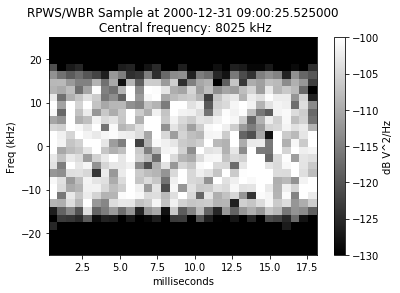

In [7]:
spec, freq, t = mlab.specgram(data_cal, NFFT=128, Fs=1/time_sampling_step, noverlap=0, mode='psd')
plt.pcolormesh(t*1000,freq/1000-62.5,10*numpy.log10(numpy.abs(spec))-hfr_gain, vmin=-130, vmax=-100, cmap='gray')
clb = plt.colorbar()
clb.set_label('dB V^2/Hz')
plt.xlabel("milliseconds")
plt.ylabel("Freq (kHz)")
plt.ylim((-25,25))
plt.title("RPWS/WBR Sample at {}\n Central frequency: {} kHz".format(date_sample, frequency))
#plt.plot([2, 4], [20, -20], 'w--')
#plt.text(1, 21, '-20 MHz/s', {'color': 'w', 'fontsize': 10})
#plt.plot([6, 10], [20, -20], 'w--')
#plt.text(5, 21, '-10 MHz/s', {'color': 'w', 'fontsize': 10})
#plt.plot([10, 18], [20, -20], 'w--')
#plt.text(9, 21, '-5 MHz/s', {'color': 'w', 'fontsize': 10})

In [19]:

# Uncomment the next line and comment the following to build all the quicklooks
#for i_sample in range(o.object['WBR_ROW_PREFIX_TABLE'].data.n_rows):
for i_sample in [0]:

    time_ramp = o.get_sample_time_axis()
    time_sampling_step = time_ramp[1]
    date_sample = o.get_start_sample_datetime()[i_sample]
    frequency = o.get_central_frequency()[i_sample]
    wbr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.gain[i_sample]['TOTAL_GAIN']

    hfr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.get_agc_gain()[i_sample]

    data = o.object['TIME_SERIES'].data['WBR_SAMPLE'][i_sample]
    data_cal = (data - numpy.average(data))/267.31/10**(wbr_gain/20)
    
    spec, freq, t = mlab.specgram(data_cal, NFFT=128, Fs=1/time_sampling_step, noverlap=0, mode='psd')
    plt.pcolormesh(t*1000,freq/1000-63,10*numpy.log10(numpy.abs(spec))-hfr_gain,vmin=-130,vmax=-100, cmap='plasma')
    clb = plt.colorbar()
    clb.set_label('dB V^2/Hz')
    plt.xlabel("milliseconds")
    plt.ylabel("Freq (kHz)")
    plt.ylim((-25,25))
    plt.title("RPWS/WBR Sample at {}\n Central frequency: {} kHz".format(date_sample, frequency))
    plt.plot([2, 4], [20, -20], 'w--')
    plt.text(1, 21, '-20 MHz/s', {'color': 'w', 'fontsize': 10})
    plt.plot([6, 10], [20, -20], 'w--')
    plt.text(5, 21, '-10 MHz/s', {'color': 'w', 'fontsize': 10})
    plt.plot([10, 18], [20, -20], 'w--')
    plt.text(9, 21, '-5 MHz/s', {'color': 'w', 'fontsize': 10})
    plt.savefig('{}-{}-{}_{:03d}_psd.png'.format(date_sample.year,date_sample.month,date_sample.day, i_sample))
    plt.close()

In [21]:
o.object['WBR_ROW_PREFIX_TABLE'].data.keys()

dict_keys(['AGC', 'SCLK_FINE', 'DATA_RTI', 'SCLK_PARTITION', 'LP_DAC_1', 'FSW_VER', 'RECORD_BYTES', 'SCET_DAY', 'HFR_XLATE', 'LP_DAC_0', 'SAMPLES', 'SCET_MILLISECOND', 'SCLK_SECOND', 'GAIN', 'FREQUENCY_BAND', 'VALIDITY_FLAG', 'ANTENNA', 'SUB_RTI', 'STATUS_FLAG'])

In [35]:
print('VALIDITY_FLAG:  {:08b}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['VALIDITY_FLAG'][i_sample]))
print('STATUS_FLAG:    {:08b}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['STATUS_FLAG'][i_sample]))
print('FREQUENCY_BAND: {}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['FREQUENCY_BAND'][i_sample]))
print('GAIN byte:      {:08b}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['GAIN'][i_sample]))
print('ANTENNA:        {}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['ANTENNA'][i_sample]))
print('AGC:            {}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['AGC'][i_sample]))
print('HFR_XLATE:      {}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['HFR_XLATE'][i_sample]))
print('SUB_RTI:        {}'.format(o.object['WBR_ROW_PREFIX_TABLE'].data['SUB_RTI'][i_sample]))

VALIDITY_FLAG:  11000100
STATUS_FLAG:    10001000
FREQUENCY_BAND: 3
GAIN byte:      00000100
ANTENNA:        8
AGC:            36
HFR_XLATE:      80
SUB_RTI:        0


-20 MHz/s = -20 kHz/ms

(850, 1450)

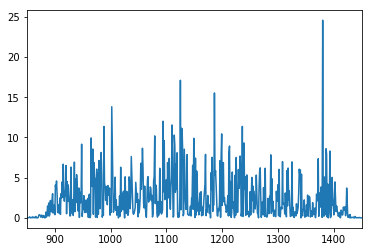

In [37]:
import scipy
ft = scipy.fft(data_cal)
plt.plot(abs(ft)**2)
plt.xlim((850,1450))

In [38]:
n_samples = o.object['TIME_SERIES'].data.n_rows
dynspect = numpy.zeros((4096,n_samples), dtype=numpy.float32)

for i_sample in range(n_samples):
    wbr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.gain[i_sample]['TOTAL_GAIN']
    hfr_gain = o.object['WBR_ROW_PREFIX_TABLE'].data.get_agc_gain()[i_sample]
    data = o.object['TIME_SERIES'].data['WBR_SAMPLE'][i_sample]
    data_cal = (data - numpy.average(data))/267.31/10**(wbr_gain/20)
    
    dynspect[:,i_sample] = abs(scipy.fft(data))**2
    

In [39]:
noise_5pc = numpy.zeros((4096,), dtype=numpy.float32)
max_spect = numpy.zeros((4096,), dtype=numpy.float32)
min_spect = numpy.zeros((4096,), dtype=numpy.float32)
med_spect = numpy.zeros((4096,), dtype=numpy.float32)
avg_spect = numpy.zeros((4096,), dtype=numpy.float32)

for i_freq in range(4096):
    noise_5pc[i_freq] = numpy.percentile(dynspect[i_freq,:], 5)
    max_spect[i_freq] = numpy.max(dynspect[i_freq,:])
    min_spect[i_freq] = numpy.min(dynspect[i_freq,:])
    med_spect[i_freq] = numpy.median(dynspect[i_freq,:])
    avg_spect[i_freq] = numpy.average(dynspect[i_freq,:])



In [40]:
def smoothGaussian(list,strippedXs=False,degree=5):  

     window=degree*2-1  
     weight=numpy.array([1.0]*window)  
     weightGauss=[]  
        
     for i in range(window):  
         i=i-degree+1  
         frac=i/float(window)  
         gauss=1/(numpy.exp((4*(frac))**2))  
         weightGauss.append(gauss)  

     weight=numpy.array(weightGauss)*weight  
     smoothed=[0.0]*(len(list)-window)  

     for i in range(len(smoothed)):  
         smoothed[i]=sum(numpy.array(list[i:i+window])*weight)/sum(weight)  

     return smoothed  



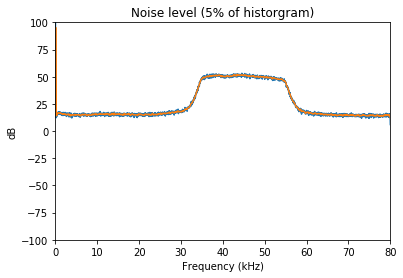

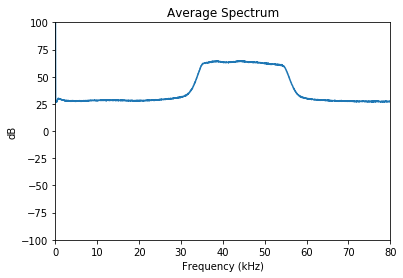

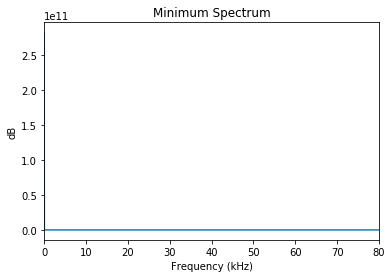

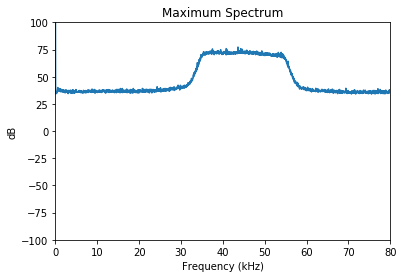

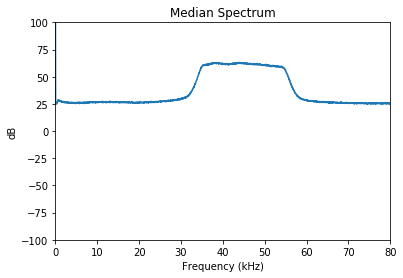

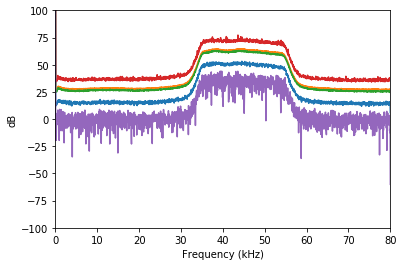

In [41]:
freq = numpy.linspace(0,160,4096)

plt.plot(freq, 10*numpy.log10(noise_5pc))
plt.plot(freq[4:4091], 10*numpy.log10(smoothGaussian(noise_5pc,degree=5)))
plt.xlim((0,80))
plt.ylim((-100,100))
plt.title('Noise level (5% of historgram)')
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.show()

plt.plot(freq, 10*numpy.log10(avg_spect))
plt.xlim((0,80))
plt.ylim((-100,100))
plt.title('Average Spectrum')
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.show()


plt.plot(freq, min_spect)
plt.xlim((0,80))
plt.title('Minimum Spectrum')
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.show()


plt.plot(freq, 10*numpy.log10(max_spect))
plt.title('Maximum Spectrum')
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.xlim((0,80))
plt.ylim((-100,100))
plt.show()

plt.plot(freq, 10*numpy.log10(med_spect))
plt.title('Median Spectrum')
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.xlim((0,80))
plt.ylim((-100,100))
plt.show()

plt.plot(freq, 10*numpy.log10(noise_5pc))
plt.plot(freq, 10*numpy.log10(avg_spect))
plt.plot(freq, 10*numpy.log10(med_spect))
plt.plot(freq, 10*numpy.log10(max_spect))
plt.plot(freq, 10*numpy.log10(numpy.maximum(min_spect, 1e-6)))
plt.ylabel('dB')
plt.xlabel('Frequency (kHz)')
plt.xlim((0,80))
plt.ylim((-100,100))
plt.show()








/Users/baptiste/Development/pyvenv/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 80)

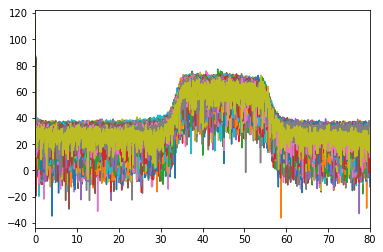

In [42]:

for i_sample in range(n_samples):
    plt.plot(freq, 10*numpy.log10(dynspect[:, i_sample]))
plt.xlim((0,80))


In [43]:
wbr_gain = []
hfr_gain = []
for i_sample in range(n_samples):
    wbr_gain.append(o.object['WBR_ROW_PREFIX_TABLE'].data.gain[i_sample]['TOTAL_GAIN'])
    hfr_gain.append(o.object['WBR_ROW_PREFIX_TABLE'].data.get_agc_gain()[i_sample])
    

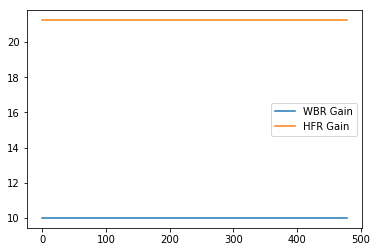

In [44]:
plt.plot(wbr_gain,label='WBR Gain')
plt.plot(hfr_gain,label='HFR Gain')
plt.legend()